In [1]:
import pandas as pd
import numpy as np
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


## Loading and merging survey files

In [2]:
valid_folder = '../data/'
valid_file = 'wellcome_sentence_human_valid.csv'

In [3]:
df_sent = pd.read_csv(valid_folder + valid_file)
df_sent = df_sent.rename(columns = {'Unnamed: 0': 'ID'}).set_index('ID', drop=True)

In [4]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2311 to 20701
Data columns (total 4 columns):
Dominant_Topic       200 non-null int64
Perc_Contribution    200 non-null float64
texts                200 non-null object
random               200 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 7.8+ KB


In [5]:
survey_folder = valid_folder + 'validation/'

In [6]:
df_survey = pd.DataFrame(columns=['ID', 'label_1', 'label_2']).set_index('ID', drop=True)
for i, file in enumerate(glob.glob(survey_folder + "*.tsv")):
    df_temp = pd.read_csv(file, sep = '\t',  usecols = ['Unnamed: 0','label'])
    df_temp = df_temp.rename(columns = {'Unnamed: 0': 'ID', 'label': 'label_1'}).set_index('ID', drop=True)
    if i == 0:
        df_survey = pd.concat([df_survey, df_temp], sort=False)
    elif (i > 0) & (i < 9):
        df_temp_1 = df_temp.iloc[:20].copy()
        df_temp_1.rename(columns = {'label_1': 'label_2'}, inplace=True)
        df_temp_2 = df_temp.iloc[20:].copy()
        
        df_survey.update(df_temp_1)
        df_survey = pd.concat([df_survey, df_temp_2], sort=False)
    else:
        df_temp.rename(columns = {'label_1': 'label_2'}, inplace=True)
        df_survey.update(df_temp)
        
    

In [7]:
df_survey = df_survey.join(df_sent)
df_survey[["label_1", "label_2"]] = df_survey[["label_1", "label_2"]].apply(lambda df: df.astype(int))

In [8]:
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2311 to 20701
Data columns (total 6 columns):
label_1              200 non-null int64
label_2              200 non-null int64
Dominant_Topic       200 non-null int64
Perc_Contribution    200 non-null float64
texts                200 non-null object
random               200 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 20.9+ KB


final_file = 'wellcome_sentence_human_valid_results.csv'
df_survey.to_csv(valid_folder + final_file)

## Statistics on surveyed sentences

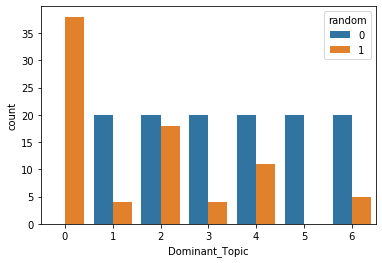

In [9]:
# Biased vs random sampling (0 is biased, 1 is random)
ax = sns.countplot(x="Dominant_Topic", hue="random", data=df_survey);

Random sampling overpopulates Group 0 and underpopulates all the others, except Group 2 

In [10]:
# Group assignment according to labels

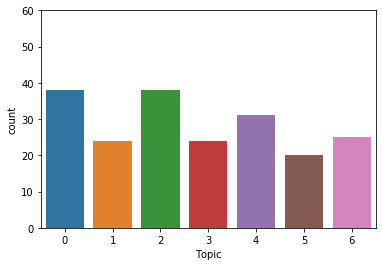

In [11]:
ax = sns.countplot(x="Dominant_Topic", data=df_survey);
ax.set_ylim([0, 60]);
ax.set_xlabel('Topic');

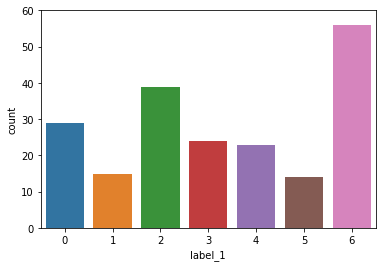

In [12]:
ax = sns.countplot(x="label_1", data=df_survey);
ax.set_ylim([0, 60]);

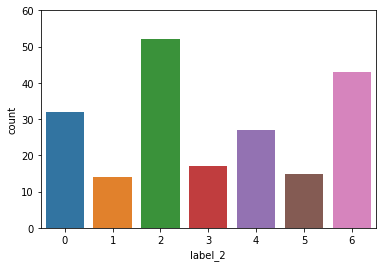

In [13]:
ax = sns.countplot(x="label_2", data=df_survey);
ax.set_ylim([0, 60]);

Human labels vs predicted labels:
- Group 0 is underrepresented (model is conservative in considering noise)
- Group 1 is underrepresented
- Group 2 is overrepresented
- Group 3 is equally represented
- Group 4 is equally represented
- Group 5 is slightly underrepresented
- Group 6 is largely overrepresented

Definition of Group 6 is too vague: needs action.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_xticklabels(classes)
    ax.set_xlabel('Label 2')

    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_yticklabels(classes)
    ax.set_ylabel('Label 1')
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

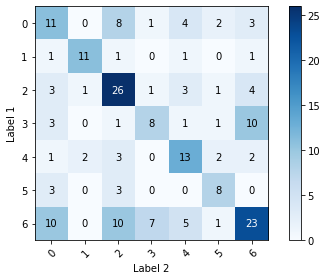

In [15]:
# Show confusion matrix of Label 1 VS Label 2
plot_confusion_matrix(df_survey['label_1'], df_survey['label_2']); 

In [16]:
# Group sentences together: assign them to each group if at least one label is of that group
result_array = np.empty((7,8))
for i in range(0,7):
    df_group = df_survey[(df_survey.label_1 == i) | (df_survey.label_2 == i)]
    a = np.concatenate((df_group.label_1.values, df_group.label_2.values))
    result_array[i,0] = len(a)
    result_array[i,1:] = np.around(np.bincount(a)/len(a) * 100, 1)

index_list = ['Group ' + str(i) for i in range(7)]
column_list = ['Total']
for i in range(7):
    column_list.append(str(i))

df_result = pd.DataFrame(data=result_array,    # values
             index=index_list,    # 1st column as index
             columns=column_list)  # 1st row as the column names
df_result['Total'] = df_result['Total'].astype(int)

In [17]:
df_result

,Total,0,1,2,3,4,5,6
Group 0,100,61.0,1.0,11.0,4.0,5.0,5.0,13.0
Group 1,36,2.8,80.6,5.6,0.0,8.3,0.0,2.8
Group 2,130,8.5,1.5,70.0,1.5,4.6,3.1,10.8
Group 3,66,6.1,0.0,3.0,62.1,1.5,1.5,25.8
Group 4,74,6.8,4.1,8.1,1.4,67.6,2.7,9.5
Group 5,42,11.9,0.0,9.5,2.4,4.8,69.0,2.4
Group 6,152,8.6,0.7,9.2,11.2,4.6,0.7,65.1


Mislabeling between the 2 human sets (ignoring Group 0, no label):
- Group 1: good agreement (80%), slight overlap with Group 4
- Group 2: decent agreement (70%), slight overlap with Group 6
- Group 3: poor agreement (62%), major overlap with Group 6 (26%)
- Group 4: decent agreement (68%), slight overlaps with Group 2 and Group 6
- Group 5: decent agreement (69%), slight overlap with Group 2
- Group 6: poor agreement (65%), overlaps with Group 2 and Group 3

As already mentioned, definition of Group 6 is too vague (overlaps with majority of other groups).

## Comparison with model

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_xticklabels(classes)
    ax.set_xlabel('Predicted')

    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_yticklabels(classes)
    ax.set_ylabel('Respondent')
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

              precision    recall  f1-score   support

           0       0.27      0.36      0.31        11
           1       0.73      1.00      0.85        11
           2       0.47      0.35      0.40        26
           3       0.55      0.75      0.63         8
           4       0.33      0.46      0.39        13
           5       0.71      0.62      0.67         8
           6       0.40      0.26      0.32        23

    accuracy                           0.47       100
   macro avg       0.50      0.54      0.51       100
weighted avg       0.47      0.47      0.46       100



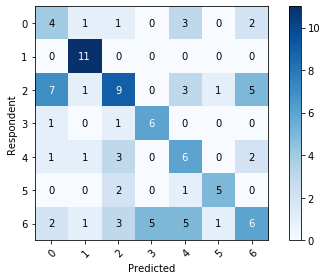

In [22]:
# Validation report (when the two human labels agree)

df_survey_same = df_survey[df_survey.label_1 == df_survey.label_2]
y_true = df_survey_same['label_1']
y_pred = df_survey_same['Dominant_Topic']
plot_confusion_matrix(y_true, y_pred); 
classes = unique_labels(y_true, y_pred).astype(str)
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        61
           1       0.58      0.90      0.71        31
           2       0.58      0.47      0.52        93
           3       0.67      0.67      0.67        48
           4       0.42      0.55      0.48        47
           5       0.60      0.73      0.66        33
           6       0.56      0.32      0.41        87

    accuracy                           0.53       400
   macro avg       0.54      0.59      0.55       400
weighted avg       0.54      0.53      0.52       400



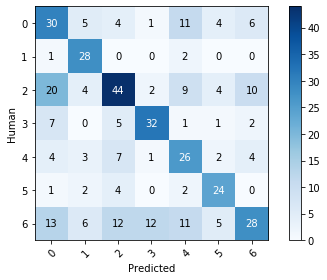

In [20]:
# Validation report (when at least one label agrees with model)

df_survey_loose = df_survey.loc[:, ['label_1', 'label_2', 'Dominant_Topic']]
# Duplicate dataframe
df_survey_loose = pd.concat([df_survey_loose, df_survey_loose])

# Assign new column:
# - label_2 if agrees with model, otherwise label_1
df_survey_loose['label_3'] = np.where(df_survey_loose.label_2 == df_survey_loose.Dominant_Topic, 
                                      df_survey_loose.label_2, 
                                      df_survey_loose.label_1)
# On duplicate:
# - label_1 if agrees with model, otherwise label_2
df_survey_loose.iloc[200:, 3] = np.where(df_survey_loose.iloc[200:, 0] == df_survey_loose.iloc[200:, 2], 
                                      df_survey_loose.iloc[200:, 0], 
                                      df_survey_loose.iloc[200:, 1])

y_true = df_survey_loose['label_3']
y_pred = df_survey_loose['Dominant_Topic']
plot_confusion_matrix(y_true, y_pred); 
classes = unique_labels(y_true, y_pred).astype(str)
print(classification_report(y_true, y_pred, target_names=classes))